# Galaxy vs quasars

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
gal_qso = pd.read_csv("galaxyquasar.csv")

In [3]:
gal_qso

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [4]:
u_g = gal_qso['u']-gal_qso['g']
g_r = gal_qso['g']-gal_qso['r']
r_i = gal_qso['r']-gal_qso['i']
i_z = gal_qso['i']-gal_qso['z']
objclass = gal_qso['class']
objclass.replace({'GALAXY': 0, 'QSO': 1}, inplace=True)

labels = ['u - g', 'g - r', 'r - i', 'i - z']

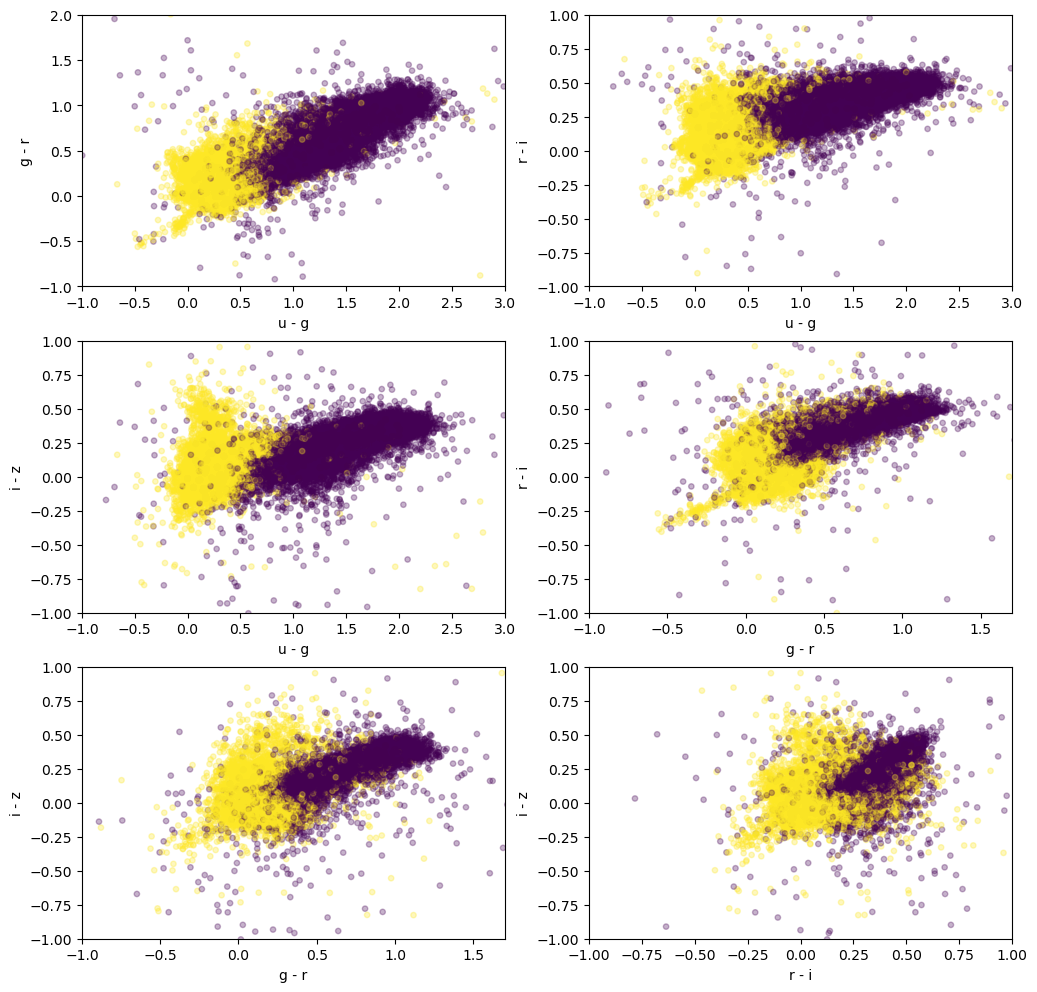

In [5]:
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(321)
ax.scatter(u_g, g_r, c=[objclass[j] for j in range(50000)], s=15, alpha=0.3)
ax.set_xlabel(labels[0])
ax.set_ylabel(labels[1])
ax.set_xlim(-1, 3)
ax.set_ylim(-1, 2)

ax = fig.add_subplot(322)
ax.scatter(u_g, r_i, c=[objclass[j] for j in range(50000)], s=15, alpha=0.3)
ax.set_xlabel(labels[0])
ax.set_ylabel(labels[2])
ax.set_xlim(-1, 3)
ax.set_ylim(-1, 1)

ax = fig.add_subplot(323)
ax.scatter(u_g, i_z, c=[objclass[j] for j in range(50000)], s=15, alpha=0.3)
ax.set_xlabel(labels[0])
ax.set_ylabel(labels[3])
ax.set_xlim(-1, 3)
ax.set_ylim(-1, 1)

ax = fig.add_subplot(324)
ax.scatter(g_r, r_i, c=[objclass[j] for j in range(50000)], s=15, alpha=0.3)
ax.set_xlabel(labels[1])
ax.set_ylabel(labels[2])
ax.set_xlim(-1, 1.7)
ax.set_ylim(-1, 1)

ax = fig.add_subplot(325)
ax.scatter(g_r, i_z, c=[objclass[j] for j in range(50000)], s=15, alpha=0.3)
ax.set_xlabel(labels[1])
ax.set_ylabel(labels[3])
ax.set_xlim(-1, 1.7)
ax.set_ylim(-1, 1)

ax = fig.add_subplot(326)
ax.scatter(r_i, i_z, c=[objclass[j] for j in range(50000)], s=15, alpha=0.3)
ax.set_xlabel(labels[2])
ax.set_ylabel(labels[3])
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

plt.show()

## Gaussian Naive Bayes

In [5]:
from sklearn.naive_bayes import GaussianNB
from astroML.utils import split_samples
from astroML.utils import completeness_contamination
from sklearn.metrics import precision_recall_curve, roc_curve

In [6]:
# Prepare data
X = np.array([u_g, g_r, r_i, i_z]).T
y = np.array(objclass)
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25], random_state=70)

N_tot = len(y)
N_st = np.sum(y == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)

### 1D

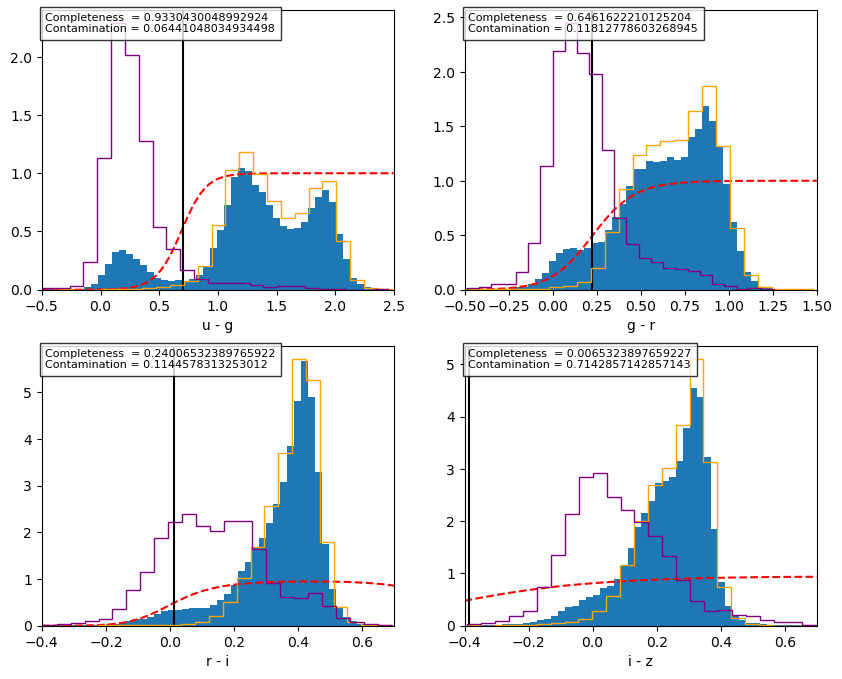

In [44]:
xlim = [[-0.5, 2.5],
        [-0.5, 1.5],
        [-0.4, 0.7],
        [-0.4, 0.7]]

fig = plt.figure(figsize=(10,8))

predictions = []
for i in range(4):
    clf = GaussianNB()
    clf.fit(X_train[:, i:i+1], y_train)
    y_predGNB = clf.predict(X_test[:, i:i+1])
   
    completeness, contamination = completeness_contamination(y_predGNB, y_test)

    xx = np.linspace(xlim[i][0], xlim[i][1], 81)

    Z = clf.predict_proba(np.c_[xx.ravel()])
    Z[:, 1].reshape(xx.shape)
    
    ax = fig.add_subplot(2,2,i+1)
    ax.hist(X[:,i][(X[:,i]>xlim[i][0]) & (X[:,i]<xlim[i][1])], bins=50, density=True)
    ax.plot(xx, Z[:, 0].reshape(xx.shape), 'r--')
    ax.axvline(xx[np.abs(Z[:,0] - 0.5).argmin()], c='k')
    ax.set_xlabel(labels[i])
    ax.set_xlim(xlim[i][0], xlim[i][1])
    
    ax.hist(X[:,i][(X[:,i]>xlim[i][0]) & (X[:,i]<xlim[i][1]) & ([objclass[j]==0 for j in range(50000)])], 
            bins=25, histtype='step', color='orange', density=True)
    ax.hist(X[:,i][(X[:,i]>xlim[i][0]) & (X[:,i]<xlim[i][1]) & ([objclass[j]==1 for j in range(50000)])], 
            bins=25, histtype='step', color='purple', density=True)
    
    ax.text(0.01, 0.99, "Completeness  = "+str(completeness)+"\nContamination = "+str(contamination), transform=ax.transAxes, ha='left', va='top', fontsize=8, bbox=dict(facecolor='white', alpha=0.8))


plt.show()

From a 1D analysis, we can see that the data can be classified quite well when considering the u-g and g-r colors, but it becomes much more difficult with the other two colors. This is reasonable, as the histograms of the first two colors show some bimodality, while the histograms of the last two do not.

Let's see if we can improve the classification performance by considering more colors.

### Adding other colors

completeness [0.933043   0.92868808 0.92270005 0.92324442]
contamination [0.06441048 0.11099531 0.10695469 0.1134344 ]


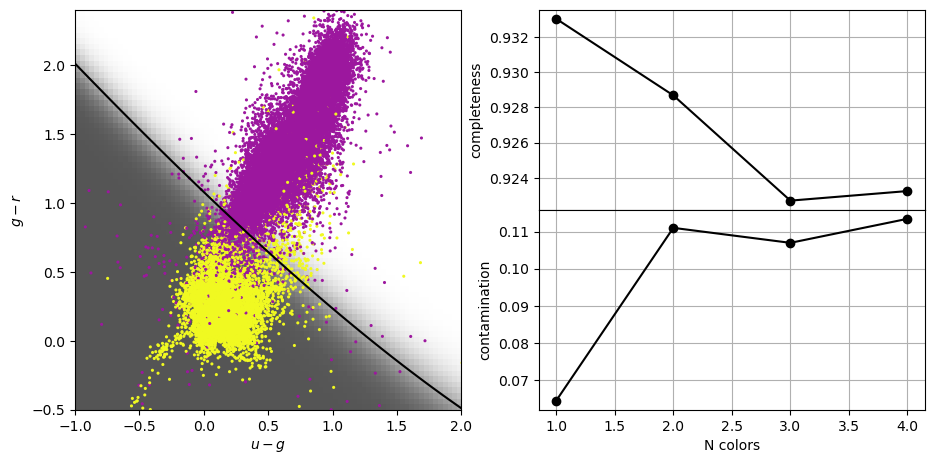

In [11]:
classifiers = []
predictions = []
Ncolors = np.arange(1, X.shape[1] + 1)

for nc in Ncolors:
    clf = GaussianNB()
    clf.fit(X_train[:, :nc], y_train)
    y_predGNB = clf.predict(X_test[:, :nc])
    
    classifiers.append(clf)
    predictions.append(y_predGNB)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

#------------------------------------------------------------
# Compute the decision boundary
clf = classifiers[1]
xlim = (-1, 2)
ylim = (-0.5, 2.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 81),
                     np.linspace(ylim[0], ylim[1], 71))

Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])
Z = Z[:, 1].reshape(xx.shape)

#---------------------------------------------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[:, 1], X[:, 0], c=y[:],
                s=5, lw=0, cmap=plt.cm.plasma, zorder=2)
im.set_clim(-0.5, 1)

im = ax.imshow(Z, origin='lower', aspect='auto',
               cmap=plt.cm.binary, zorder=1,
               extent=xlim + ylim)
im.set_clim(0, 1.5)
ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

#--------------------------------------------------------------------------------------------------------
# Plot completeness vs Ncolors
ax = plt.subplot(222)
ax.plot(Ncolors, completeness, 'o-k', ms=6)

ax.set_ylabel('completeness')
#ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# Plot contamination vs Ncolors
ax = plt.subplot(224)
ax.plot(Ncolors, contamination, 'o-k', ms=6)

ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
#ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

In [12]:
# manual computation of completeness and contamination
from sklearn.metrics import confusion_matrix

col_text = ['1 color', '2 colors', '3 colors', '4 colors']
for i in range(4):
    print(col_text[i])
    CM = confusion_matrix(y_test, predictions[i])
    print(CM)

    compl = CM[1,1]/(CM[1,1]+CM[1,0])     # TP/(TP+FN)
    cont = CM[0,1]/(CM[1,1]+CM[0,1])      # FP/(FP*TP)
    print(compl, cont, '\n')

1 color
[[10545   118]
 [  123  1714]]
0.9330430048992924 0.06441048034934498 

2 colors
[[10450   213]
 [  131  1706]]
0.9286880783886772 0.11099531005732152 

3 colors
[[10460   203]
 [  142  1695]]
0.9227000544365814 0.10695468914646997 

4 colors
[[10446   217]
 [  141  1696]]
0.9232444202504083 0.1134343962362781 



## Linear & Quadratic Discriminant Analysis

### 2 colors

In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

...................LDA...............QDA.............
completeness  0.9286880783886772 0.9352204681545999
contamination 0.06315211422295441 0.07235421166306695


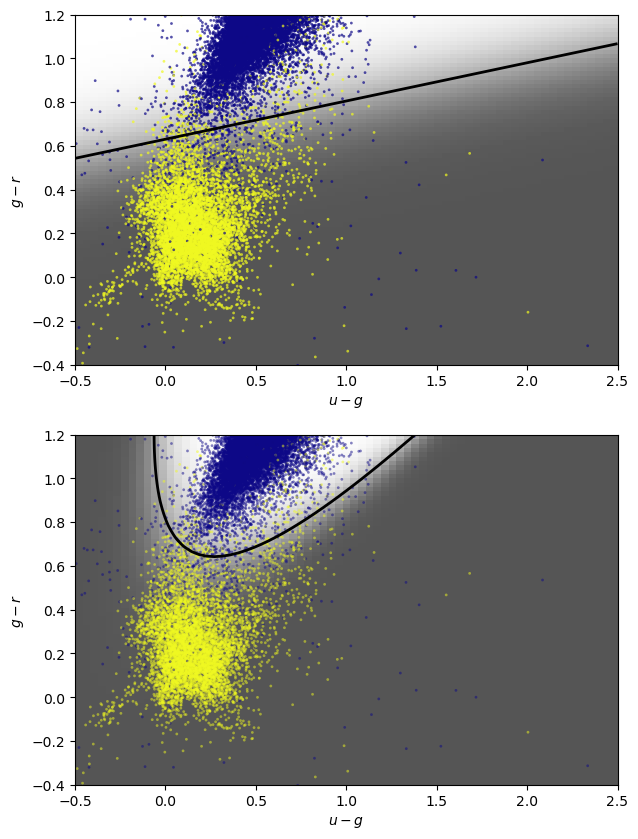

In [14]:
N_tot = len(y)
N_stars = np.sum(y == 0)
N_rrlyrae = N_tot - N_stars
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rrlyrae

#----------------------------------------------------------------------
# perform LDA
lda = LDA()
lda.fit(X_train[:, :2], y_train)
y_predLDA = lda.predict(X_test[:, :2])

# perform QDA
qda = QDA()
qda.fit(X_train[:, :2], y_train)
y_predQDA = qda.predict(X_test[:, :2])
    
completenessLDA, contaminationLDA = completeness_contamination(y_predLDA, y_test)
completenessQDA, contaminationQDA = completeness_contamination(y_predQDA, y_test)

print("...................LDA...............QDA.............")
print("completeness ", completenessLDA,  completenessQDA)
print("contamination", contaminationLDA, contaminationQDA)

#------------------------------------------------------------
# Compute the decision boundary
xlim = (-0.5, 2.5)
ylim = (-0.4, 1.2)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71),
                     np.linspace(ylim[0], ylim[1], 81))

Z_LDA = lda.predict_proba(np.c_[yy.ravel(), xx.ravel()])
Z_LDA = Z_LDA[:, 1].reshape(xx.shape)
Z_QDA = qda.predict_proba(np.c_[yy.ravel(), xx.ravel()])
Z_QDA = Z_QDA[:, 1].reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(7, 10))

# left plot: data and decision boundary
ax = fig.add_subplot(211)
im = ax.scatter(X[:, 1], X[:, 0], c=y[:],
                s=4, lw=0, cmap='plasma', alpha=0.7, zorder=2)

im = ax.imshow(Z_LDA, origin='lower', aspect='auto',
               cmap=plt.cm.binary, zorder=1,
               extent=xlim + ylim)
im.set_clim(0, 1.5)

ax.contour(xx, yy, Z_LDA, [0.5], linewidths=2., colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

# right plot: qda
ax = fig.add_subplot(212)
im = ax.scatter(X[:, 1], X[:, 0], c=y[:],
                s=4, lw=0, cmap='plasma', alpha=0.5, zorder=2)

im = ax.imshow(Z_QDA, origin='lower', aspect='auto',
               cmap=plt.cm.binary, zorder=1,
               extent=xlim + ylim)
im.set_clim(0, 1.5)

ax.contour(xx, yy, Z_QDA, [0.5], linewidths=2., colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

plt.show()

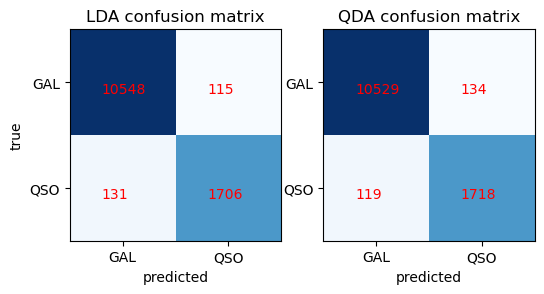

In [15]:
# confusion matrix
LCM = confusion_matrix(y_test, y_predLDA)
QCM = confusion_matrix(y_test, y_predQDA)

fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(121)
plt.imshow(np.log(LCM), cmap='Blues', interpolation='nearest')
for i in range(2):
    for j in range(2):
        plt.text(i-0.2,j+0.1,LCM[j,i],c='r')
plt.ylabel('true')
plt.xlabel('predicted')
plt.title('LDA confusion matrix')
plt.xticks(np.arange(0,2), ['GAL','QSO'])
plt.yticks(np.arange(0,2), ['GAL','QSO'])

ax = fig.add_subplot(122)
plt.imshow(np.log(LCM), cmap='Blues', interpolation='nearest')
for i in range(2):
    for j in range(2):
        plt.text(i-0.2,j+0.1,QCM[j,i],c='r')
#plt.ylabel('true')
plt.xlabel('predicted')
plt.title('QDA confusion matrix')
plt.xticks(np.arange(0,2), ['GAL','QSO'])
plt.yticks(np.arange(0,2), ['GAL','QSO'])

plt.show()

### Adding colors

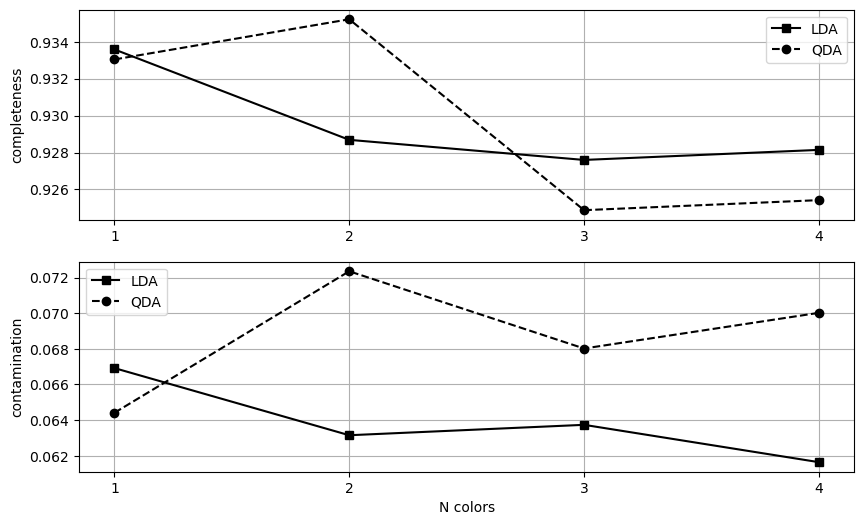

In [16]:
completenessLDA = []
contaminationLDA = []
completenessQDA = []
contaminationQDA = []

for i in range(4):
    # perform LDA
    lda = LDA()
    lda.fit(X_train[:, :i+1], y_train)
    y_predLDA = lda.predict(X_test[:, :i+1])

    # perform QDA
    qda = QDA()
    qda.fit(X_train[:, :i+1], y_train)
    y_predQDA = qda.predict(X_test[:, :i+1])

    completenessLDA.append( completeness_contamination(y_predLDA, y_test)[0] )
    contaminationLDA.append( completeness_contamination(y_predLDA, y_test)[1] )
    
    completenessQDA.append( completeness_contamination(y_predQDA, y_test)[0] )
    contaminationQDA.append( completeness_contamination(y_predQDA, y_test)[1] )

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(211)
ax.plot(completenessLDA, 'sk-', label='LDA')
ax.plot(completenessQDA, 'ok--', label='QDA')
ax.grid()
ax.set_xticks(np.arange(4),np.arange(1,5))
ax.set_ylabel('completeness')
ax.legend()

ax = fig.add_subplot(212)
ax.plot(contaminationLDA, 'sk-', label='LDA')
ax.plot(contaminationQDA, 'ok--', label='QDA')
ax.grid()
ax.set_xticks(np.arange(4),np.arange(1,5))
ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.legend()
plt.show()

## GMM Bayes Classifier

In [17]:
from astroML.classification import GMMBayes

completeness [[0.933043   0.93522047 0.92487752 0.92542188]
 [0.9346761  0.92651062 0.93413174 0.94175286]]
contamination [[0.06441048 0.07235421 0.06801975 0.07002188]
 [0.0723933  0.06122449 0.05662452 0.05978261]]


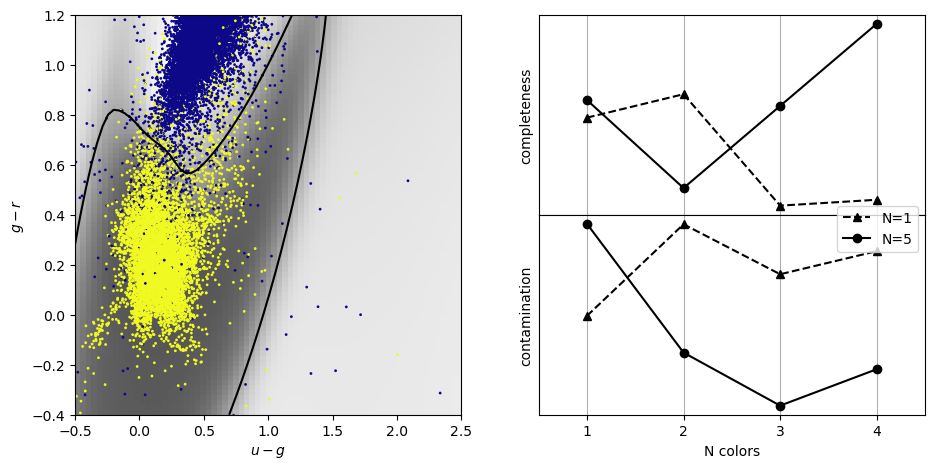

In [18]:
N_tot = len(y)
N_st = np.sum(y == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rr

#----------------------------------------------------------------------
# perform GMM Bayes
Ncolors = np.arange(1, X.shape[1] + 1)
Ncomp = [1, 5]


def compute_GMMbayes(Ncolors, Ncomp):
    classifiers = []
    predictions = []

    for ncm in Ncomp:
        classifiers.append([])
        predictions.append([])
        for nc in Ncolors:
            clf = GMMBayes(ncm, tol=1E-5, covariance_type='full')
            clf.fit(X_train[:, :nc], y_train)
            y_pred = clf.predict(X_test[:, :nc])

            classifiers[-1].append(clf)
            predictions[-1].append(y_pred)

    return classifiers, predictions

classifiers, predictions = compute_GMMbayes(Ncolors, Ncomp)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

#------------------------------------------------------------
# Compute the decision boundary
clf = classifiers[1][1]
xlim = (-0.5, 2.5)
ylim = (-0.4, 1.2)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71),
                     np.linspace(ylim[0], ylim[1], 81))

Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])
Z = Z[:, 1].reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[:, 1], X[:, 0], c=y[:],
                s=4, lw=0, cmap='plasma', zorder=2)
#im.set_clim(-0.5, 1)

im = ax.imshow(Z, origin='lower', aspect='auto',
               cmap=plt.cm.binary, zorder=1,
               extent=xlim + ylim)
im.set_clim(0, 1.5)

ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

# plot completeness vs Ncolors
ax = fig.add_subplot(222)
ax.plot(Ncolors, completeness[0], '^--k', ms=6, label='N=%i' % Ncomp[0])
ax.plot(Ncolors, completeness[1], 'o-k', ms=6, label='N=%i' % Ncomp[1])
#ax.plot(Ncolors, completeness[2], 's:k', ms=6, label='N=%i' % Ncomp[2])

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
#ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination[0], '^--k', ms=6, label='N=%i' % Ncomp[0])
ax.plot(Ncolors, contamination[1], 'o-k', ms=6, label='N=%i' % Ncomp[1])
#ax.plot(Ncolors, contamination[2], 's:k', ms=6, label='N=%i' % Ncomp[2])

ax.legend(loc='lower right',
          bbox_to_anchor=(1.0, 0.78))

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))

ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
#ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

## Methods comparison with 4 colors

/home/sandokan/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


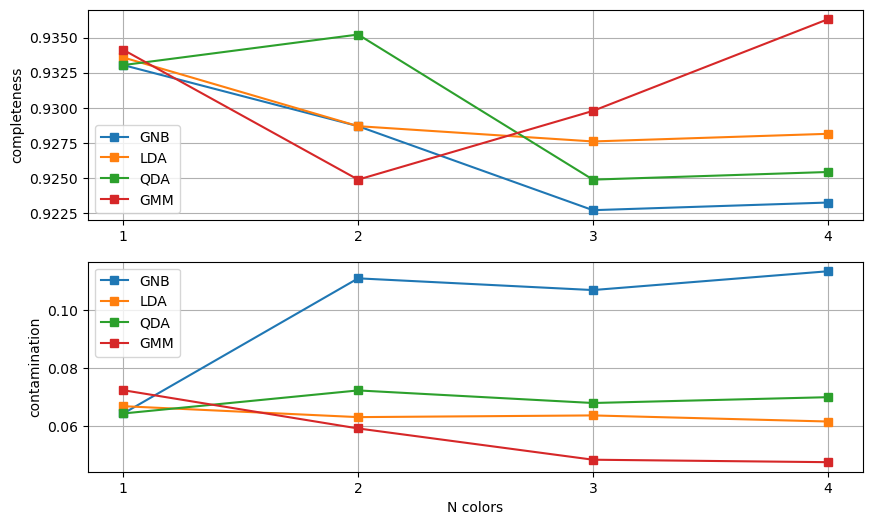

In [33]:
completenessGNB = []
completenessLDA = []
completenessQDA = []
completenessGMM = []

contaminationGNB = []
contaminationLDA = []
contaminationQDA = []
contaminationGMM = []

for i in range(1,5):
    
    # perform GNB
    gnb = GaussianNB()
    gnb.fit(X_train[:, :i], y_train)
    y_predGNB = gnb.predict(X_test[:, :i])
    
    completenessGNB.append( completeness_contamination(y_predGNB, y_test)[0] )
    contaminationGNB.append( completeness_contamination(y_predGNB, y_test)[1] )
    
    # perform LDA
    lda = LDA()
    lda.fit(X_train[:, :i], y_train)
    y_predLDA = lda.predict(X_test[:, :i])
    
    completenessLDA.append( completeness_contamination(y_predLDA, y_test)[0] )
    contaminationLDA.append( completeness_contamination(y_predLDA, y_test)[1] )

    # perform QDA
    qda = QDA()
    qda.fit(X_train[:, :i], y_train)
    y_predQDA = qda.predict(X_test[:, :i])

    completenessQDA.append( completeness_contamination(y_predQDA, y_test)[0] )
    contaminationQDA.append( completeness_contamination(y_predQDA, y_test)[1] )
    
    # perform GMM
    Ncomp = 5
    gmm = GMMBayes(Ncomp, tol=1E-5, covariance_type='full')
    gmm.fit(X_train[:, :i], y_train)
    y_predGMM = gmm.predict(X_test[:, :i])
    
    completenessGMM.append( completeness_contamination(y_predGMM, y_test)[0] )
    contaminationGMM.append( completeness_contamination(y_predGMM, y_test)[1] )

    
# plot completeness and contamination
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(211)
ax.plot(completenessGNB, 's-', label='GNB')
ax.plot(completenessLDA, 's-', label='LDA')
ax.plot(completenessQDA, 's-', label='QDA')
ax.plot(completenessGMM, 's-', label='GMM')
ax.grid()
ax.set_xticks(np.arange(4),np.arange(1,5))
ax.set_ylabel('completeness')
ax.legend()

ax = fig.add_subplot(212)
ax.plot(contaminationGNB, 's-', label='GNB')
ax.plot(contaminationLDA, 's-', label='LDA')
ax.plot(contaminationQDA, 's-', label='QDA')
ax.plot(contaminationGMM, 's-', label='GMM')
ax.grid()
ax.set_xticks(np.arange(4),np.arange(1,5))
ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.legend()
plt.show()

From the completeness and contaminations plots, we can say that the best classification method, using all the colors, is a Gaussian Mixture Model Bayes Classifier, which produces the lowest contamination and highest completeness. We draw the ROC curve and the efficiency for a better comparison.

### ROC curve

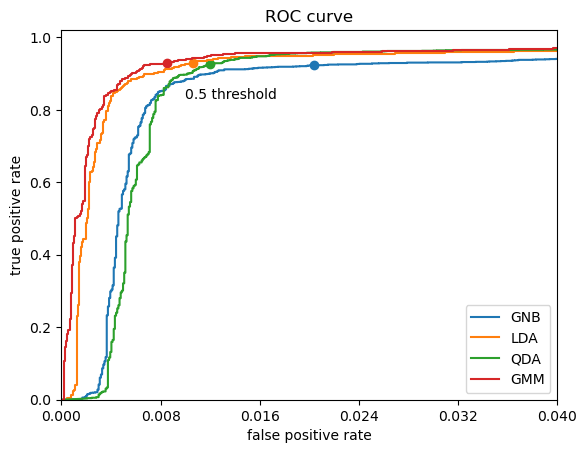

In [34]:
thresholds = np.linspace(0, 1, 1001)[:-1]

#------------------------------------------------------------
# train and predict
clf = GaussianNB()
clf.fit(X_train, y_train)
probGNB = clf.predict_proba(X_test)[:,1]
compGNB = np.zeros_like(thresholds)
contGNB = np.zeros_like(thresholds)
for i, t in enumerate(thresholds):
    y_pred = (probGNB >= t)
    compGNB[i], contGNB[i] = completeness_contamination(y_pred, y_test)
    
clf = LDA()
clf.fit(X_train, y_train)
probLDA = clf.predict_proba(X_test)[:,1]
compLDA = np.zeros_like(thresholds)
contLDA = np.zeros_like(thresholds)
for i, t in enumerate(thresholds):
    y_pred = (probLDA >= t)
    compLDA[i], contLDA[i] = completeness_contamination(y_pred, y_test)
    
clf = QDA()
clf.fit(X_train, y_train)
probQDA = clf.predict_proba(X_test)[:,1]
compQDA = np.zeros_like(thresholds)
contQDA = np.zeros_like(thresholds)
for i, t in enumerate(thresholds):
    y_pred = (probQDA >= t)
    compQDA[i], contQDA[i] = completeness_contamination(y_pred, y_test)
    
clf = GMMBayes(5, tol=1E-5, covariance_type='full')
clf.fit(X_train, y_train)
probGMM = clf.predict_proba(X_test)[:,1]
compGMM = np.zeros_like(thresholds)
contGMM = np.zeros_like(thresholds)
for i, t in enumerate(thresholds):
    y_pred = (probGMM >= t)
    compGMM[i], contGMM[i] = completeness_contamination(y_pred, y_test)
    
#------------------------------------------------------------
# Plot ROC curves 
fig = plt.figure()
ax1 = plt.subplot()

fpr, tpr, thresh = roc_curve(y_test, probGNB)
ax1.plot(fpr, tpr, label='GNB')
tx, ty = fpr[np.argmin(abs(thresh-0.5))], tpr[np.argmin(abs(thresh-0.5))]
ax1.scatter(tx,ty)


fpr, tpr, thresh = roc_curve(y_test, probLDA)
ax1.plot(fpr, tpr, label='LDA')
tx, ty = fpr[np.argmin(abs(thresh-0.5))], tpr[np.argmin(abs(thresh-0.5))]
ax1.scatter(tx,ty)

fpr, tpr, thresh = roc_curve(y_test, probQDA)
ax1.plot(fpr, tpr, label='QDA')
tx, ty = fpr[np.argmin(abs(thresh-0.5))], tpr[np.argmin(abs(thresh-0.5))]
ax1.scatter(tx,ty)

fpr, tpr, thresh = roc_curve(y_test, probGMM)
ax1.plot(fpr, tpr, label='GMM')
tx, ty = fpr[np.argmin(abs(thresh-0.5))], tpr[np.argmin(abs(thresh-0.5))]
ax1.scatter(tx,ty)

ax1.text(0.01, 0.83, '0.5 threshold')

ax1.set_xlim(0, 0.04)
ax1.set_ylim(0, 1.02)
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')
ax1.set_title('ROC curve')
ax1.legend(loc=4)

plt.show()

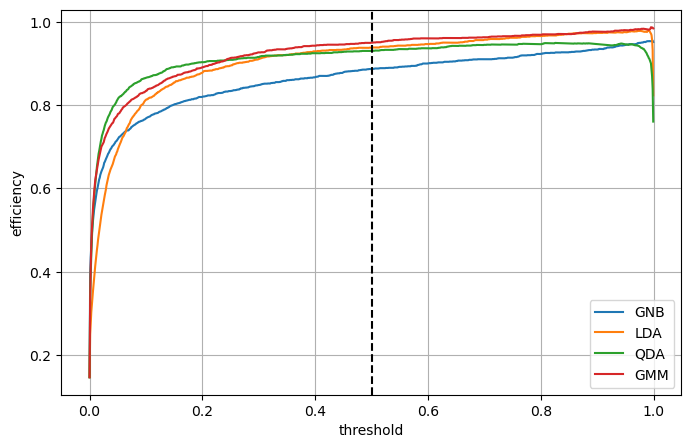

In [35]:
plt.figure(figsize=(8,5))
plt.plot(thresholds, 1-contGNB, label='GNB')
plt.plot(thresholds, 1-contLDA, label='LDA')
plt.plot(thresholds, 1-contQDA, label='QDA')
plt.plot(thresholds, 1-contGMM, label='GMM')

plt.axvline(0.5, c='k', linestyle='--')

plt.grid()
plt.xlabel('threshold')
plt.ylabel('efficiency')
plt.legend()
plt.show()

If we choose a threshold = 0.5 the best classification method is the GMM Bayes, followed by LDA and QDA approaches. The Gaussian Naive Bayes is clearly the worst method. We can make these statements from the ROC curve (better methods the ones with higher tpr and smaller fpr) and the plot of the efficiency.